## This Notebook transfers a 288x1 Input (Values for Insulin) into a XxX Array

Import the required packages

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from utils.loading import load_table
import os

import pandas as pd
import plotly.express as px
import numpy as np

import tensorflow.keras.layers as tfl
import tensorflow as tf

import datetime
pd.set_option('display.max_rows', 1000)

## Parameters

In [3]:
CSV_INPUT = 'df_final_1.csv'
CONV_INPUT_LENGTH = 288
TRAIN_TEST_SPLIT = 0.8
GLUCOSE_OPTIMUM = 85

## Load data

In [4]:
df_raw = pd.read_csv(os.path.join('..', CSV_INPUT), )
df = df_raw.copy(deep=True)

In [5]:
df = df.sort_values('LocalDtTm')
train_length = int(TRAIN_TEST_SPLIT*df.shape[0])
df_train = df.iloc[:train_length,:]
df_test = df.iloc[train_length:,:]
assert df_test.shape[0] + df_train.shape[0] == df.shape[0]

X_train = df_train.drop(columns=['LocalDtTm', 'CGM'])
Y_train = df_train[['CGM']]

X_test = df_test.drop(columns=['LocalDtTm', 'CGM'])
Y_test = df_test[['CGM']]

## Model

In [6]:
# Custom loss function
class GlucoseLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, glucose_optimum=GLUCOSE_OPTIMUM):
        y_true = tf.cast(y_true, tf.float32) 
        return (y_pred-y_true)**2 * ((y_true-glucose_optimum)**2+6000)


In [7]:
# Custom metric
def hyper_metric(y_true, y_pred):
    
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.greater(y_true, 100.0))
    return tf.reduce_mean(tf.cast(tf.greater(preds_while_hyper, 100.0), tf.float32))

# Custom metric
def hypo_metric(y_true, y_pred):
    
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.less(y_true, 70.0))
    return tf.reduce_mean(tf.cast(tf.less(preds_while_hyper, 70.0), tf.float32))


In [35]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ConvLayer, self).__init__()
        self.conv1 = tfl.Conv1D(filters = 3, kernel_size = 5, strides = 1, padding = 'valid')
        self.pool1 = tfl.MaxPool1D(pool_size = 2, strides = 2, padding = 'valid')
        self.conv2 = tfl.Conv1D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid')
        self.pool2 = tfl.MaxPool1D(pool_size = 6, strides = 4, padding = 'valid')
        self.flatten = tfl.Flatten()


    def build(self, input_shape):
        pass

    def call(self, input):
            
        assert input.shape[1] == CONV_INPUT_LENGTH
        # 1st CONV
        print(f'Conv1d {input.shape}')
        conv1_out = self.conv1(input)
        # Max Pool
        pool1_out = self.pool1(conv1_out)
        # 2nd CONV
        conv2_out = self.conv2(pool1_out)
        # Max Pool
        pool2_out = self.pool2(conv2_out)
        # Now flatten the Matrix into a 1D vector (shape 1x204)
        flatten_out = self.flatten(pool2_out)

        #assert Flatten.shape[2] == 204
        return flatten_out

In [41]:
def get_model():
    
    #Arguments: input_shape -- of shape 1x1x288, holds the insulin values
    
    # define the input with specified shape
    input = tf.keras.Input(shape =(CONV_INPUT_LENGTH*4,1), batch_size=None)
    batch_size = tf.shape(input)[0]
    
    diabetes_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*0,0], size=[batch_size,CONV_INPUT_LENGTH,1], name='diabetes_input')
    meal_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*1,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    smbg_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*2,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    excercise_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*3,0], size=[batch_size,CONV_INPUT_LENGTH,1])

    diabetes_conv = ConvLayer()(diabetes_input)
    meal_conv = ConvLayer()(meal_input)
    smbg_conv = ConvLayer()(smbg_input)
    excercise_conv = ConvLayer()(excercise_input)

    post_conv = tf.concat([diabetes_conv, meal_conv, smbg_conv, excercise_conv], axis=1, name='post_conv')
    
    assert post_conv.shape[1] == 204*4

    # Now fully connect layers
    FC1 = tfl.Dense(units = 512, activation = 'relu')(post_conv)
    # output a vector of shape 1x84
    FC2 = tfl.Dense(units = 256, activation = 'relu')(FC1)
    FC3 = tfl.Dense(units = 128, activation = 'relu')(FC2)
    FC4 = tfl.Dense(units = 64, activation = 'relu')(FC3)
    output = tfl.Dense(units = 1, activation = None)(FC4)

    # continuous function for blood glucose value
    # ...
    
    model = tf.keras.Model(inputs = input, outputs = output)
    return model

Now try the function:

In [42]:
conv_model = get_model()
conv_model.compile(optimizer='adam',
                  loss=GlucoseLoss(), 
                  metrics=['mse', hypo_metric, hyper_metric])
conv_model.summary()
    

Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1152, 1)]    0           []                               
                                                                                                  
 tf.compat.v1.shape_7 (TFOpLamb  (3,)                0           ['input_8[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_7 (Sl  ()                  0           ['tf.compat.v1.shape_7[0][0]']   
 icingOpLambda)                                                                                   
    

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
132/136 [============================>.] - ETA: 0s - loss: 120054832.0000 - mse: 7015.0840 - hypo_metric: nan - hyper_metric: nanConv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
136/136 [==============================] - 2s 8ms/step - loss: 119654264.0000 - mse: 6972.1118 - hypo_metric: nan - hyper_metric: nan - val_loss: 189847424.0000 - val_mse: 6032.5659 - val_hypo_metric: nan - val_hyper_metric: 0.6663
Epoch 2/10
136/136 [==============================] - 2s 12ms/step - loss: 66392344.0000 - mse: 4587.7119 - hypo_metric: nan - hyper_metric: nan - val_loss: 125237240.0000 - val_mse: 3643.7375 - val_hypo_metric: nan - val_hyper_metric: 0.9275
Epoch 3/10
136/136 [==============================] - 2s 12ms/step - loss: 51359620.0000 - mse: 3728.0134 - hypo_metric: 

In [12]:
#px.scatter(Y_test, conv_model.predict(X_test))

#conv_model.predict(Y_).shape
conv_model.predict(X_train).shape
df_raw.shape

272/272 [==============================] - 1s 4ms/step


(10844, 1154)

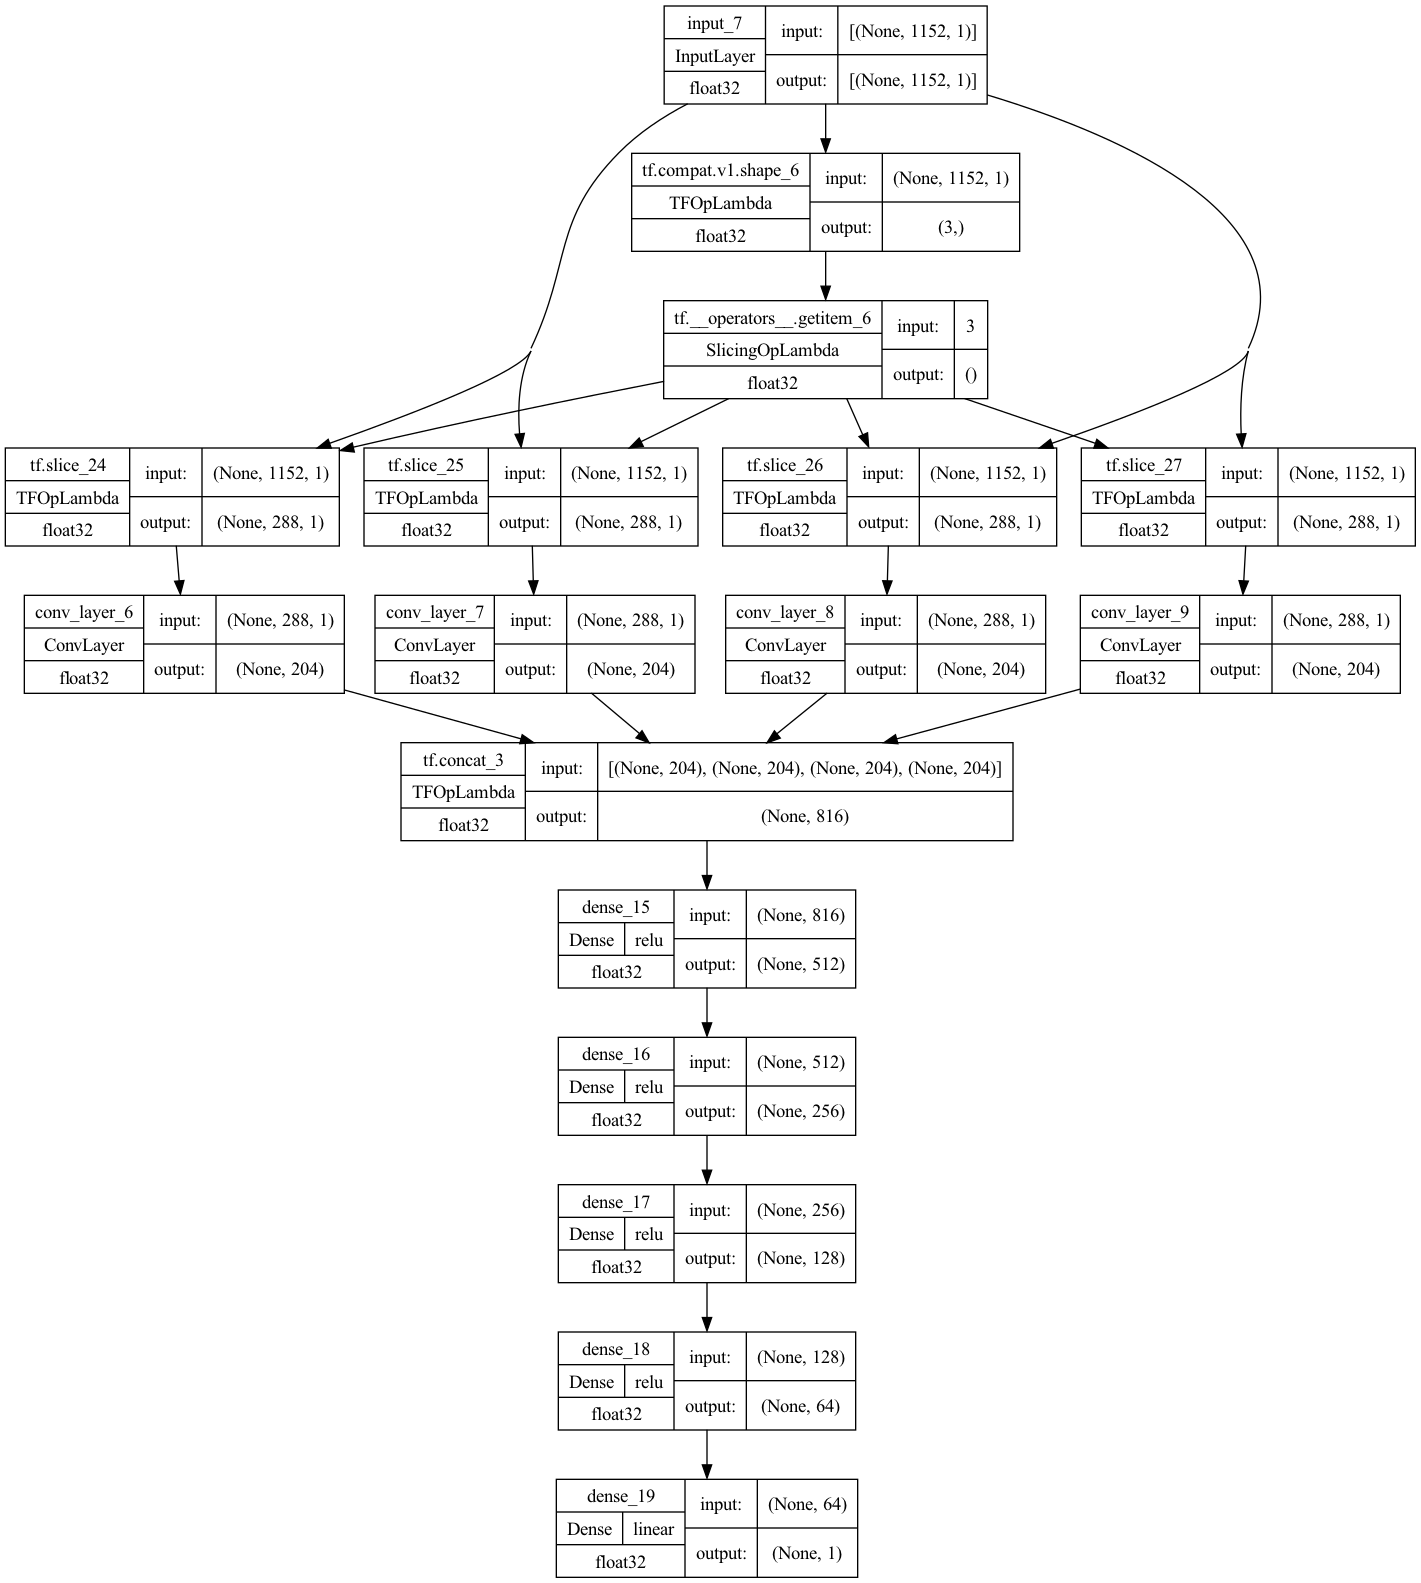

In [40]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)
